In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from math import pi
from numpy import fft
from mpi4py import MPI

def my_plot(x, y, title, xlabel, ylabel, fig_x_size = 15, fig_y_size = 10, font_param = 20):
    plt.figure(figsize=(fig_x_size, fig_y_size))
    plt.plot(x, y, "g.--")    
    plt.title(title, fontsize = font_param * 1.3)
    plt.xlabel(xlabel, fontsize = font_param)
    plt.ylabel(ylabel, fontsize = font_param)
    plt.xticks(fontsize = font_param)
    plt.yticks(fontsize = font_param)
    
def my_imshow(x, y, z, 
              title, 
              xlabel, 
              ylabel,
              grid_active = False, fig_x_size = 15, fig_y_size = 10, font_param = 20):
    
    plt.figure(figsize=(fig_x_size, fig_y_size))
    plt.imshow(z, aspect='auto', 
               origin='lower', 
               extent=[min(x)/2/pi, max(x)/2/pi, y[0], 2 * w[int(len(x)/2)-1]])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=font_param)
    plt.title(title, fontsize = font_param * 1.3)
    plt.xlabel(xlabel, fontsize = font_param)
    plt.ylabel(ylabel, fontsize = font_param)
    plt.xticks(fontsize = font_param)
    plt.yticks(fontsize = font_param)
    plt.grid(grid_active)
    

def my_second_imshow(x, y, z, 
              title, 
              xlabel, 
              ylabel,
              grid_active = False, fig_x_size = 15, fig_y_size = 10, font_param = 20):
    
    plt.figure(figsize=(fig_x_size, fig_y_size))
    plt.imshow(z, aspect='auto', 
               origin='lower', 
               extent=[min(x)/2/pi, max(x)/2/pi, y[0], 2 * w[int(len(x)/2)-1]])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=font_param)
    plt.title(title, fontsize = font_param * 1.3)
    plt.xlabel(xlabel, fontsize = font_param)
    plt.ylabel(ylabel, fontsize = font_param)
    plt.xticks(fontsize = font_param)
    plt.yticks(fontsize = font_param)
    plt.grid(grid_active)
    plt.close()
    
def form_signal(n_timestamps = 4096):
    t=np.linspace(-20*2*pi, 20*2*pi, n_timestamps)
    y=np.sin(t)*np.exp(-t**2/2/20**2)               #generate first  wave packets of harmonic signal
    y=y+np.sin(3*t)*np.exp(-(t-5*2*pi)**2/2/20**2)  #add      second wave packets of harmonic signal
    y=y+np.sin(5*t)*np.exp(-(t-10*2*pi)**2/2/10**2) #add      third  wave packets of harmonic signal
    return t, y


def window_function(t, window_position, window_width):
    return np.exp(- (t - window_position) ** 2 / 2 / window_width ** 2)


def get_specgram(window_width, nwindowsteps = 1000):
    t_window_positions=np.linspace(-20 * 2 * pi, 20 * 2 * pi, nwindowsteps)

    specgram = np.empty([len(t), len(t_window_positions)])

    for i,t_window_position in enumerate(t_window_positions):
        y_window=y * window_function(t, t_window_position, window_width)
        #plot(y_window)
        specgram[:,i]=abs(fft.fft(y_window))

    return specgram

def animate(i): # Animation 
    im.set_data(array[i]) 
    
    
t, y = form_signal()
sp=fft.fft(y)
w=fft.fftfreq(len(y), d=(t[1]-t[0])/2/pi)



%matplotlib auto

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()


array = []
grid_active = False
fig_x_size = 15
fig_y_size = 10
font_param = 20
title = "Specgram"
xlabel = "t, cycles" 
ylabel = "Frequency, arb. units"
# TA Yuri told us to look at case when we have kappa 100 times smaller - we have different spectrogram
#for kappa in [(i+1)/1000 for i in range(200)]:
Kappa = [(i+1)/10 for i in range(100)]

if rank == 0:
    kappa_list = np.array_split(Kappa, size)
    splited_data = kappa_list
else:
    kappa_list = None


kappa_list = comm.scatter(kappa_list, 0)

if rank == 0:
    start_time = MPI.Wtime()

for kappa in kappa_list:
    window_width_given = kappa * 2 * pi
    nwindowsteps_given = 1000
    array.append(get_specgram(window_width = window_width_given,nwindowsteps = nwindowsteps_given))

fig = plt.figure(figsize = (fig_x_size,fig_y_size))    

im=plt.imshow(array[1], aspect='auto', 
               origin='lower', 
               extent=[min(t)/2/pi, max(t)/2/pi, w[0], 2 * w[int(len(t)/2)-1]])
#plt.close()


comm.Barrier()

if rank == 0:
    end_time = MPI.Wtime()
    
im = comm.gather(im, root=0)

if rank == 0:
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=font_param)
    plt.title(title, fontsize = font_param * 1.3)
    plt.xlabel(xlabel, fontsize = font_param)
    plt.ylabel(ylabel, fontsize = font_param)
    plt.xticks(fontsize = font_param)
    plt.yticks(fontsize = font_param)
    plt.grid(grid_active)
    plt.ylim(0, 10)
    ani = animation.FuncAnimation(fig, animate, len(array))
    #plt.show()
    plt.close()
    print(end_time - start_time)

Using matplotlib backend: Qt5Agg
12.25326618500003


Traceback (most recent call last):
  File "/home/alexh3/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/home/alexh3/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/home/alexh3/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/home/alexh3/anaconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1755, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-1-9c2011a27483>", line 82, in animate
    im.set_data(array[i])
AttributeError: 'list' object has no attribute 'set_data'


In [12]:
l = []
with open('time_spec_new.txt') as f:
    l = f.read().splitlines()
result = [float(l[0])/float(i) for i in l]

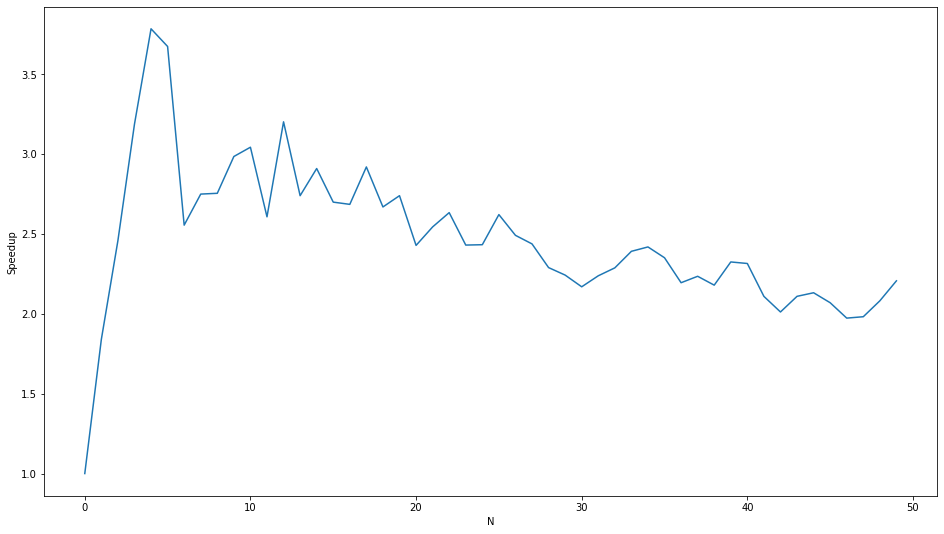

In [13]:
plt.figure(figsize = (16,9))
plt.plot(range(len(result)),result)
plt.ylabel('Speedup')
plt.xlabel('N')
plt.show()

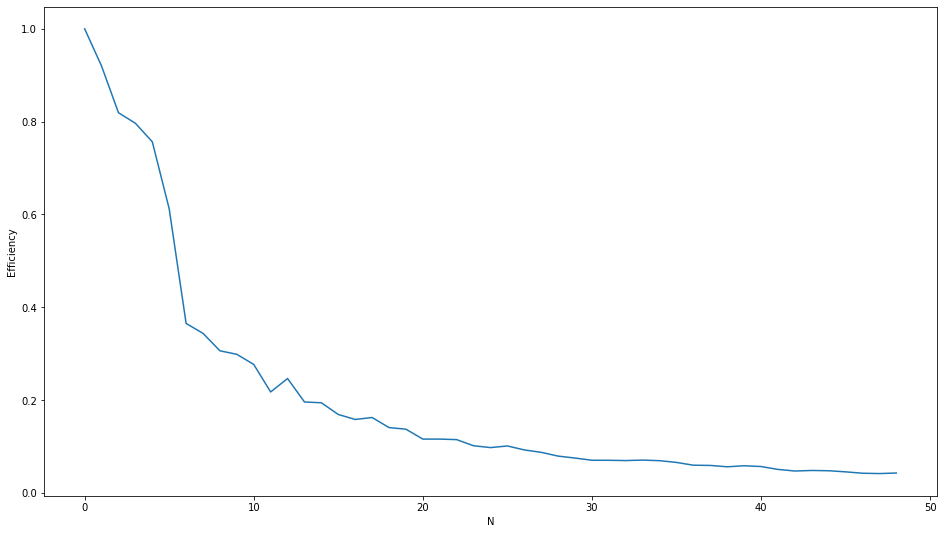

In [14]:
ef = [result[i]/(i+1) for i in range(len(result)-1)]
plt.figure(figsize = (16,9))
plt.plot(range(len(ef)),ef)
plt.ylabel('Efficiency')
plt.xlabel('N')
plt.show()